# House Price Analysis with Linear Regression

--------------------------------------------

The focus of this project will be centered around first time home buyers. 

## Data Cleaning
Data is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0         NaN   0.0          3      7        1180   
1      7242     2.0         0.0   0.0          3      7        2170   
2     10000     1.0         0.0   0.0          3      6         770   
3      5000     1.0         0.0   0.0          5      7        1050   
4      8080     1.0         0.0   0.0          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0           0.0      1955           0.0    98178  47.5112 -122.257   
1         400.0      1951        1991.0    98125  47.7210 -122.319   
2           0.0      1933           NaN    98028  47.7379 -122.233   
3         910.0      1965           0.0    98136  47.5208 -122.393   
4           0.0      1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


### Datetime

The "date" column is currently an object. Let's change it to datetime, then extract the month and year so we can use those easily. Then, drop the original date column.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

### Odd values 

In [7]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
784.0     0.000046
2050.0    0.000046
588.0     0.000046
417.0     0.000046
1920.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [8]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [9]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
784.0         1
2050.0        1
588.0         1
417.0         1
1920.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [10]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [11]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

Let's look elsewhere and see if there is anything else odd.

In [12]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21597.000000  21597.000000   21597.000000  21597.000000  17755.000000   
mean       7.657915   1788.596842     285.716581   1970.999676     83.636778   
std        1.173200    827.759761     439.819830     29.375234    399.946414   
min        3.000000    370.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     550.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  \
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000   
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512   
std       53.513072      0.138552      0.140724     685.230472   27274.441950   
min    98001.000000     47.155900   -122.519000     399.000000     651.000000   
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000   
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000   
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000   
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000   

         month_sold     year_sold  
count  21597.000000  21597.000000  
mean       6.573969   2014.322962  
std        3.115061      0.467619  
min        1.000000   2014.000000  
25%        4.000000   2014.000000  
50%        6.000000   2014.000000  
75%        9.000000   2015.000000  
max       12.000000   2015.000000

That house with 33 bedrooms is definitely odd. Let's check it out.

In [13]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

id      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
8748   1773100755   520000.0        11       3.00         3000      4960   
13301   627300145  1150000.0        10       5.25         4590     10920   
15147  5566100170   650000.0        10       2.00         3610     11914   
15856  2402100895   640000.0        33       1.75         1620      6000   
19239  8812401450   660000.0        10       3.00         2920      3745   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
8748      2.0         0.0   0.0          3      7        2400          600.0   
13301     1.0         0.0   2.0          3      9        2500         2090.0   
15147     2.0         0.0   0.0          4      7        3010          600.0   
15856     1.0         0.0   0.0          5      7        1040          580.0   
19239     2.0         0.0   0.0          4      7        1860         1060.0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
8748       1918        1999.0    98106  47.5560 -122.363           1420   
13301      2008           0.0    98004  47.5861 -122.113           2730   
15147      1958           0.0    98006  47.5705 -122.175           2040   
15856      1947           0.0    98103  47.6878 -122.331           1330   
19239      1913           0.0    98105  47.6635 -122.320           1810   

       sqft_lot15  month_sold  year_sold  
8748         4960           8       2014  
13301       10400           8       2014  
15147       11914          10       2014  
15856        4700           6       2014  
19239        3745          12       2014

Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [15]:
# Drop the 33 bedroom house then verify that it is gone
df.drop(index=15856, inplace= True)
# df[df['bedrooms'] >= 10]

### Null values

In [16]:
# look at values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [17]:
# look at values in view
df.view.value_counts(normalize= True)

0.0    0.901918
2.0    0.044443
3.0    0.023592
1.0    0.015325
4.0    0.014722
Name: view, dtype: float64

In [18]:
# look at values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958094
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [19]:
df.fillna(0, inplace= True)

### Duplicates

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [20]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [21]:
df_id_dups = df[df.duplicated('id')]

In [22]:
df_id_dups.reset_index(drop= True, inplace= True)

In [23]:
df.loc[df['id'] == 6021501535]

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
93  6021501535  430000.0         3        1.5         1580      5000     1.0   
94  6021501535  700000.0         3        1.5         1580      5000     1.0   

    waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
93         0.0   0.0          3      8        1290          290.0      1939   
94         0.0   0.0          3      8        1290          290.0      1939   

    yr_renovated  zipcode     lat     long  sqft_living15  sqft_lot15  \
93           0.0    98117  47.687 -122.386           1570        4500   
94           0.0    98117  47.687 -122.386           1570        4500   

    month_sold  year_sold  
93           7       2014  
94          12       2014

In [24]:
df.loc[df['id'] == 4139480200]

id      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
313  4139480200  1380000.0         4       3.25         4290     12103   
314  4139480200  1400000.0         4       3.25         4290     12103   

     floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
313     1.0         0.0   3.0          3     11        2690         1600.0   
314     1.0         0.0   3.0          3     11        2690         1600.0   

     yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
313      1997           0.0    98006  47.5503 -122.102           3860   
314      1997           0.0    98006  47.5503 -122.102           3860   

     sqft_lot15  month_sold  year_sold  
313       11244           6       2014  
314       11244          12       2014

In [25]:
df.loc[df['id'] == 3969300030]

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
345  3969300030  165000.0         4        1.0         1000      7134     1.0   
346  3969300030  239900.0         4        1.0         1000      7134     1.0   

     waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
345         0.0   0.0          3      6        1000            0.0      1943   
346         0.0   0.0          3      6        1000            0.0      1943   

     yr_renovated  zipcode      lat    long  sqft_living15  sqft_lot15  \
345           0.0    98178  47.4897 -122.24           1020        7138   
346           0.0    98178  47.4897 -122.24           1020        7138   

     month_sold  year_sold  
345           7       2014  
346          12       2014

It looks like the rows that have identical id numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [26]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [27]:
df.id.duplicated().sum()

0

In [28]:
df.reset_index(inplace= True, drop= True)

Great! We took care of duplicates, null values, odd values, and have correct data types.

We can move on to taking a closer look at the data.

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Data visualization is the graphical representation of data in order to interactively and efficiently convey insights to others.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21419 entries, 0 to 21418
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Questions?

Given the information we have and that we are looking at data that would be interesting to first time home buyers, let's generate some questions that might conclude some interesting answers.

1. Which season is best to buy a house if you want the lowest price?
2. Does a waterfront or view matter? Could a first time home buyer afford that?
3. Are there some grades or conditions that might be out of reach for a first time home buyer?
4. Is there an area that we can focus on or eliminate?

#### Criteria assumptions
Before we dive into those questions, it would be helpful to get rid of the information that is not pertinent to a first time home buyer. These could be things like:
* houses over a certain price
* houses with a large square footage
* houses with a lot of bedrooms

So, let's work on removing the irrelevant data.

<AxesSubplot:xlabel='price'>

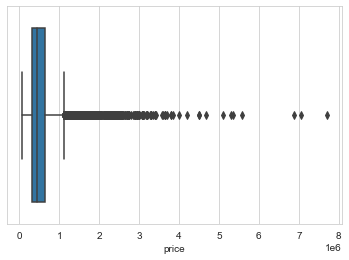

In [30]:
#  Visualize price and outliers
#  Assume for first time home buyer - budget is not more than $500,000
sns.boxplot(x= df['price'])

In [31]:
# remove houses that sold for > $800,000
df = df[df['price'] <= 800000]

<AxesSubplot:xlabel='sqft_living'>

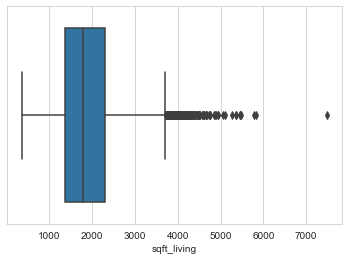

In [32]:
# Visualize houses with high square footage
sns.boxplot(x= df['sqft_living'])

In [33]:
# Whoa! Those are some large houses! Let's cut out the outliers
df = df[df['sqft_living'] <= 4000]

<AxesSubplot:xlabel='bedrooms'>

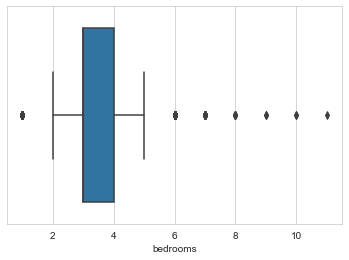

In [34]:
# Visualize bedrooms after houses with large price tags were removed
sns.boxplot(x= df['bedrooms'])

In [35]:
# remove houses with more than 6 bedrooms
df = df[df['bedrooms'] <= 6]

<AxesSubplot:xlabel='sqft_lot'>

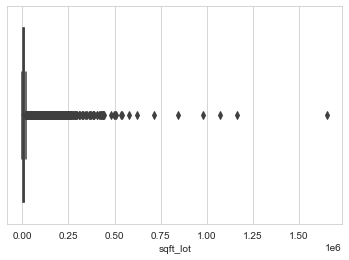

In [36]:
#check lot sizes
sns.boxplot(x= df['sqft_lot'])

In [37]:
df.loc[df['sqft_lot'] > 750000]

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
1702   1020069017  700000.0         4       1.00         1300   1651359   
4401   3626079040  790000.0         2       3.00         2560    982278   
4500   2522029039  550000.0         3       2.00         3650    843309   
7582   2623069031  542500.0         5       3.25         3010   1074218   
17149  3326079016  190000.0         2       1.00          710   1164794   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
1702      1.0         0.0   3.0          4      6        1300            0.0   
4401      1.0         0.0   0.0          3      8        2560            0.0   
4500      2.0         0.0   0.0          4      7        3650            0.0   
7582      1.5         0.0   0.0          5      8        2010         1000.0   
17149     1.0         0.0   0.0          2      5         710            0.0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
1702       1920           0.0    98022  47.2313 -122.023           2560   
4401       2004           0.0    98014  47.6955 -121.861           1620   
4500       1991           0.0    98070  47.3627 -122.496           1870   
7582       1931           0.0    98027  47.4564 -122.004           2450   
17149      1915           0.0    98014  47.6888 -121.909           1680   

       sqft_lot15  month_sold  year_sold  
1702       425581           3       2015  
4401        40946           7       2014  
4500       273992           9       2014  
7582        68825           5       2014  
17149       16730           5       2015

Only 5 lots have more than 750,000 square feet (which equals about 17.2 acres). That is still plenty of land for those first time home buyers. Let's remove those 5 houses with very large lots.

<AxesSubplot:xlabel='sqft_lot'>

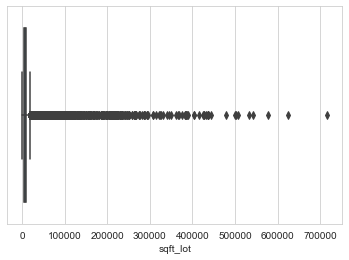

In [38]:
df = df[df['sqft_lot'] < 750000]
sns.boxplot(x= df['sqft_lot'])

#### 1. Which season is best to buy a house if you want the lowest price?

To answer this question, we will have to break the months up into seasons. Then we will find which season has the lowest average sale price.

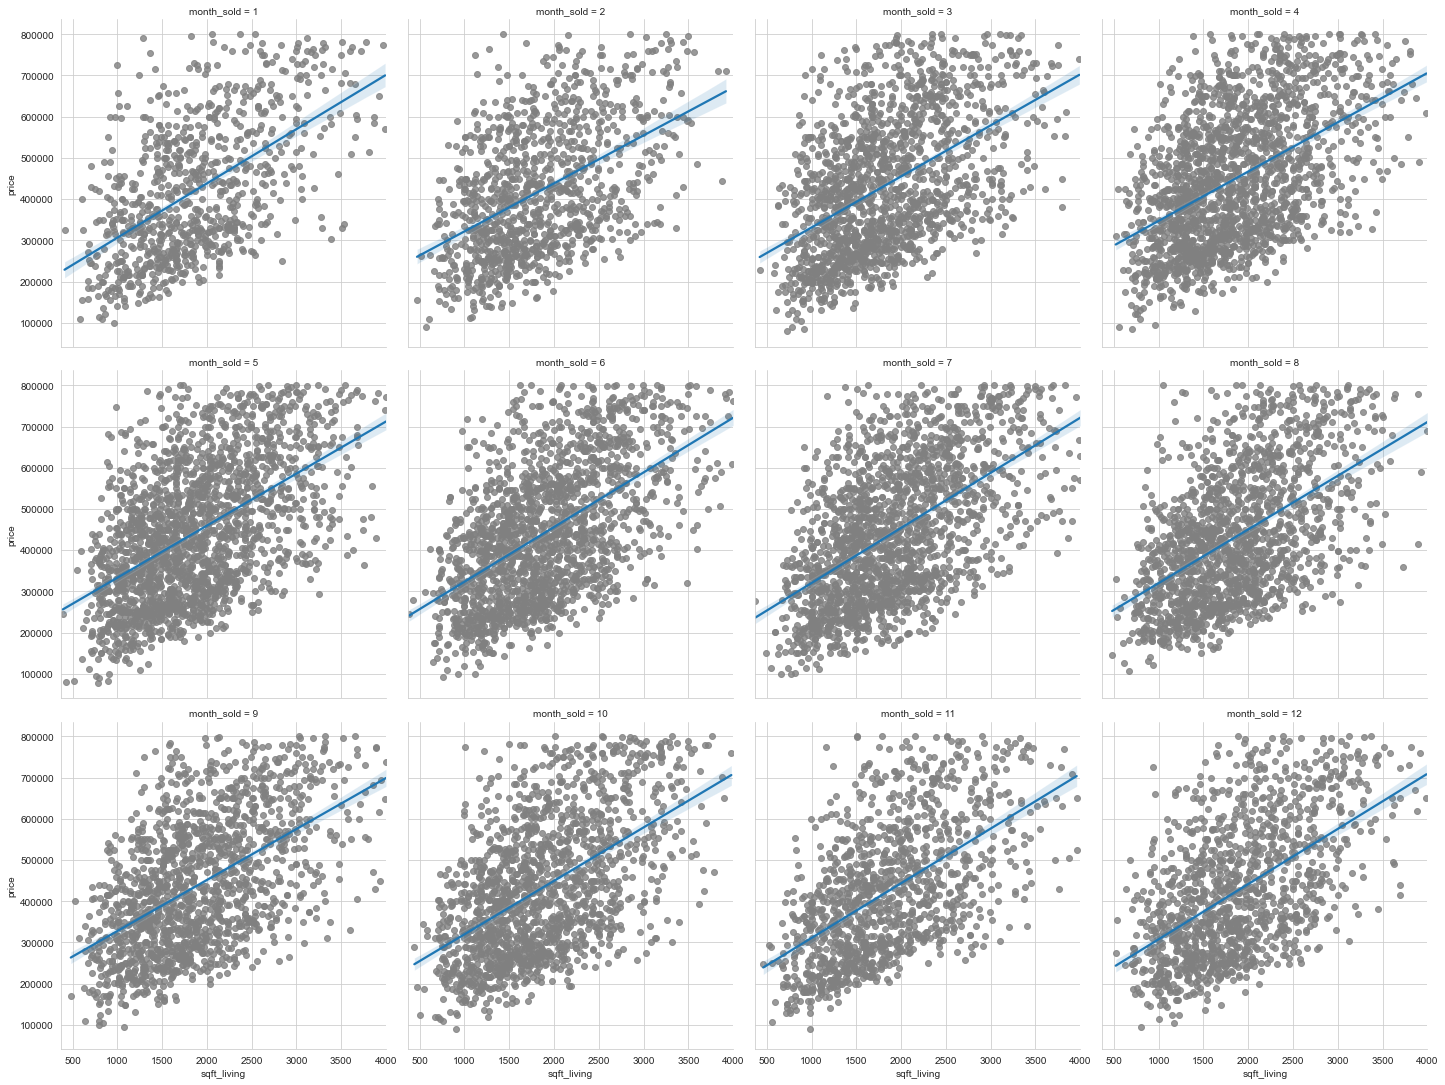

In [39]:
# First, let's look at the months and see if there appears to be a trend
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 4, scatter_kws = {'color': 'gray'})

In [40]:
# set columns for months sold
df.loc[(df['month_sold'] >= 4) & (df['month_sold'] <= 6), 'season'] = 'spring'
df.loc[(df['month_sold'] >= 7) & (df['month_sold'] <= 9), 'season'] = 'summer'
df.loc[(df['month_sold'] == 10) | (df['month_sold'] == 11), 'season'] = 'fall'
df.loc[(df['month_sold'] == 12), 'season'] = 'winter1'
df.loc[(df['month_sold'] <= 3), 'season'] = 'winter2'

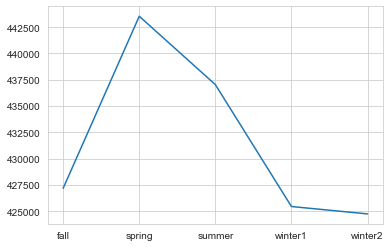

In [41]:
plt.plot(df.groupby('season')['price'].mean().round(2))

<AxesSubplot:xlabel='season', ylabel='price'>

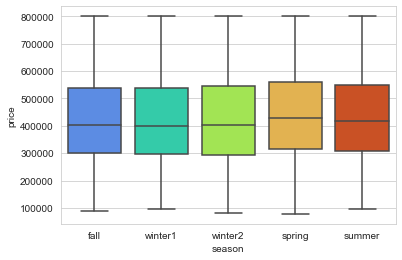

In [42]:
sns.boxplot(x= 'season', y= 'price', data= df, palette= 'turbo')

In [43]:
df_s = df.groupby('season')['price'].mean().round(2)
df_s

season
fall       427192.15
spring     443538.67
summer     437039.30
winter1    425455.78
winter2    424752.70
Name: price, dtype: float64

The most expensive season to buy a house is in spring - April through June - with the average sale price with our criteria being $443,511.71

The least expensive season to buy a house is in "winter2" or the months January through March.
The average home with our search criteria sold for $424,830.72

When comparing the line graph to the boxplot, you can now see that the amount you would be saving is difficult to see in some seasons. The savings would be about $18,000-19,000 between the least expensive time of year (January - March) and the most expensive (April - June). 

However, it is interesting to see that fall, winter1, and winter2 don't vary that much from each other. During October through March, one might expect to pay only 2K-3K more or less.

#### 2. Does a waterfront or view matter? Could a first time home buyer afford that?

Let's see how many waterfront properties or houses with views we have. When we took out higher priced homes, it may not have left much data in those features.

In [44]:
print(len(df[df['waterfront'] == 1]))
len(df[df['view'] > 0])

35


1139

In [45]:
len(df[df['waterfront'] == 1]) / len(df)

0.0019071490845684394

There were only 35 properties that were sold in the first time home buyer's criteria. If they really want a waterfront property, they may have to wait a while.

In [46]:
len(df[df['view'] > 0]) / len(df)

0.0620640802092415

While 6% of the data is still a small portion, we can leave it and see what the analysis says.

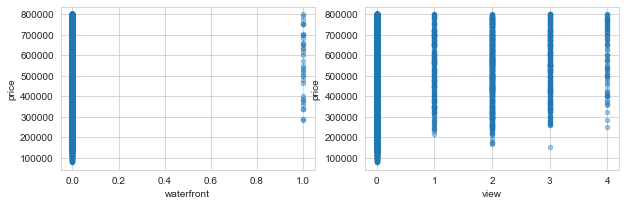

In [47]:
fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize= (10, 3))

for xcol, ax in zip([ 'waterfront', 'view'], axes):
    df.plot(kind= 'scatter', x=xcol, y= 'price', ax=ax, alpha= 0.4)

Looks like getting a house with a view could still be a possibility. It appears that there are some houses priced around $200,000 that have a view rated "2"

#### 3. Are there some grades or conditions that might be out of reach for a first time home buyer?

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

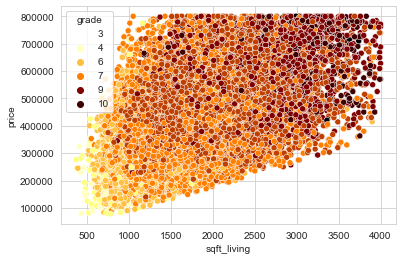

In [48]:
sns.scatterplot(x= 'sqft_living', y= 'price', hue= 'grade', data= df, 
                palette= 'afmhot_r')

Grades do seem to improve with price, but there are some smaller and less expensive homes that have higher grades.

0.001471229293809939

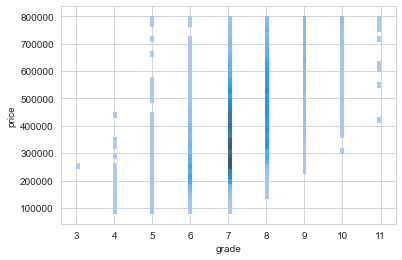

In [49]:
# #Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

# percent of houses sold with a grade "4"
len(df[df['grade'] == 4]) / len(df)

0.009971665213600697

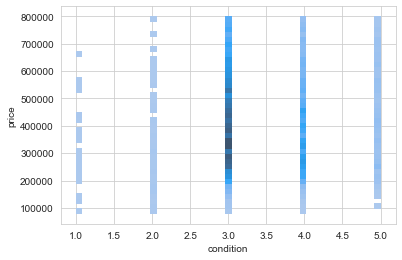

In [50]:
sns.histplot(x= 'condition', y= 'price', data= df)
# percent of houses with a condition of "1 or "2" 
len(df[df['condition'] <= 2]) / len(df)

In [51]:
df.condition.unique()

array([3, 5, 4, 1, 2])

While we may not want a first time home buyer to buy a house in poor condition, there are not many houses that would qualify. Since condition and grade can be subjective, we can leave them in and let the potential new home owner decide.

#### 4. Is there an area that we can focus on or eliminate?

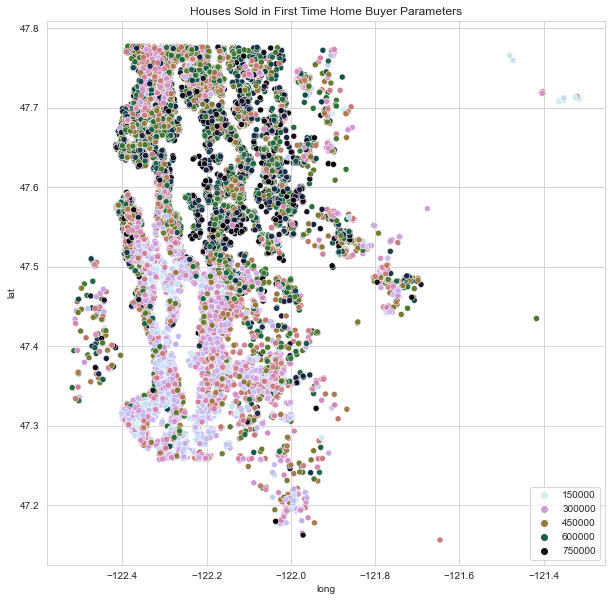

In [52]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix_r')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

Appears that the houses that sold for more are on the Northern side. We can separate the areas to see if we are correct.

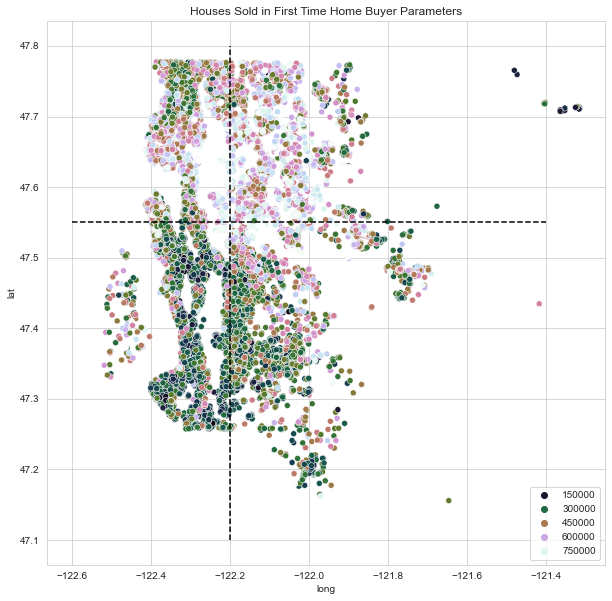

In [53]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.hlines(y=47.55, xmin=-122.6, xmax=-121.4, colors='black', linestyle='--')
plt.vlines(x=-122.2, ymin=47.1, ymax=47.8, colors='black', linestyle='--')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

That appears to separate the areas fairly evenly. Let's turn the latitude and longitude into quadrants and use the quadrants instead of zipcodes as locators.

In [54]:
df.loc[(df['lat'] >= 47.5) & (df['long'] >= -122.2), 'quadrant' ] = 'NW'
df.loc[(df['lat'] > 47.5) & (df['long'] < -122.2), 'quadrant' ] = 'NE'
df.loc[(df['lat'] <= 47.5) & (df['long'] <= -122.2), 'quadrant' ] = 'SW'
df.loc[(df['lat'] < 47.5) & (df['long'] > -122.2), 'quadrant' ] = 'SE'

In [55]:
# did it work?
# df_q3 = df[df['quadrant'] == 3]
# sns.scatterplot(x='long', y='lat', hue='price', data=df_q3, 
#                 palette= 'cubehelix')

The theory is that houses in quadrants 3 and 4 will be more affordable than those in quadrants 1 and 2.

<AxesSubplot:xlabel='quadrant', ylabel='price'>

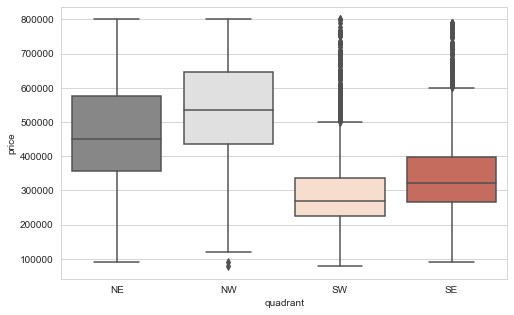

In [56]:
plt.figure(figsize= (8,5))
sns.boxplot(x= 'quadrant', y= 'price', data= df, palette= 'RdGy_r')

Looks like we were right. If we are only looking at homes that are less than $800,000, then houses in the Southern quadrants would, generally, be the least expensive.

In [57]:
df.reset_index(drop= True, inplace= True)

In [58]:
# Save a copy of cleaned and organized data before one-hot encoding or 
# dropping columns

df.to_csv('clean_df.csv')

## Feature Selection & Engineering

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

### Separate Continuous and Categorical Data

In [59]:
# use this to see which columns could be categorical or continuous data
continuous = []
categorical = []

for col in df.columns:
    if (df[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [60]:
continuous

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [61]:
categorical

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month_sold',
 'year_sold',
 'season',
 'quadrant']

Almost perfect. But I think there are some columns labeled categorical that I would consider continuous.

In [62]:
# Continuous data
con = ['id', 'price', 'sqft_living', 'sqft_lot','sqft_basement', 'yr_built', 
       'zipcode','lat','long']

In [63]:
# Categorical data
cat = ['waterfront','view','condition','grade', 'month_sold', 'year_sold', 
       'season','quadrant', 'bedrooms','bathrooms','floors', 'yr_renovated']

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>]], dtype=object)

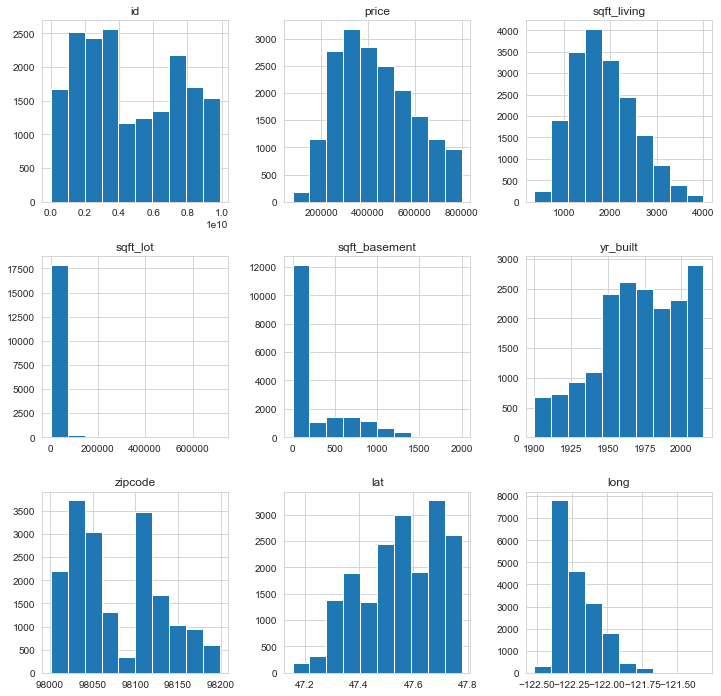

In [64]:
# Look at continuous variables
df_continuous = df.loc[:, con]
df_continuous.hist(figsize= (12, 12))

With the exception of "sqft_lot", these indeed look like they are continuous.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18352 entries, 0 to 18351
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18352 non-null  int64  
 1   price          18352 non-null  float64
 2   bedrooms       18352 non-null  int64  
 3   bathrooms      18352 non-null  float64
 4   sqft_living    18352 non-null  int64  
 5   sqft_lot       18352 non-null  int64  
 6   floors         18352 non-null  float64
 7   waterfront     18352 non-null  float64
 8   view           18352 non-null  float64
 9   condition      18352 non-null  int64  
 10  grade          18352 non-null  int64  
 11  sqft_above     18352 non-null  int64  
 12  sqft_basement  18352 non-null  float64
 13  yr_built       18352 non-null  int64  
 14  yr_renovated   18352 non-null  float64
 15  zipcode        18352 non-null  int64  
 16  lat            18352 non-null  float64
 17  long           18352 non-null  float64
 18  sqft_l

array([[<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'month_sold'}>,
        <AxesSubplot:title={'center':'year_sold'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

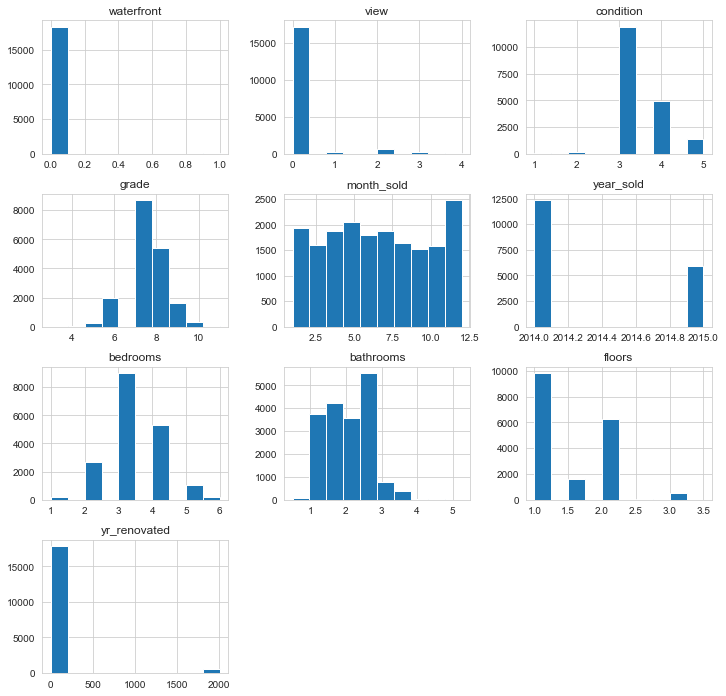

In [66]:
df_categorical = df.loc[:, cat]
df_categorical.hist(figsize= (12, 12))

Some of them could be cleaned up. But let's see what our baseline is and adjust from there.

### Baseline checks

#### Multicollinearity 

Check for interactions between other features.

In [67]:
corr = df.corr()
corr

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.000000  0.036821  0.015408   0.037375     0.026354 -0.146857   
price          0.036821  1.000000  0.246234   0.384998     0.528371  0.083327   
bedrooms       0.015408  0.246234  1.000000   0.481472     0.610827  0.020886   
bathrooms      0.037375  0.384998  0.481472   1.000000     0.687898  0.042172   
sqft_living    0.026354  0.528371  0.610827   0.687898     1.000000  0.148075   
sqft_lot      -0.146857  0.083327  0.020886   0.042172     0.148075  1.000000   
floors         0.038201  0.240558  0.135254   0.501995     0.310084 -0.037091   
waterfront    -0.007719  0.034484 -0.032920  -0.024663    -0.008897  0.020089   
view           0.021851  0.170629  0.011914   0.046425     0.113719  0.097607   
condition     -0.034351  0.028175  0.023234  -0.143519    -0.073322  0.003857   
grade          0.051994  0.545937  0.301024   0.582412     0.642017  0.073721   
sqft_above     0.032193  0.429549  0.472277   0.606960     0.828702  0.152077   
sqft_basement -0.007173  0.199535  0.269517   0.181836     0.353940  0.003278   
yr_built       0.031224  0.052394  0.178501   0.578578     0.365213  0.034539   
yr_renovated  -0.009740  0.046760 -0.013281  -0.003417     0.003100  0.016697   
zipcode       -0.005258  0.004596 -0.163926  -0.223568    -0.221519 -0.142776   
lat            0.006179  0.472662 -0.067629  -0.047454    -0.047431 -0.112327   
long           0.020733  0.073720  0.152148   0.250843     0.289546  0.239454   
sqft_living15  0.023040  0.481903  0.376363   0.502159     0.713092  0.158193   
sqft_lot15    -0.143749  0.068646  0.014544   0.039359     0.147815  0.770239   
month_sold    -0.008737 -0.006923 -0.003990   0.012410     0.016802  0.011487   
year_sold      0.005740 -0.001436 -0.003923  -0.028468    -0.029361 -0.006458   

                 floors  waterfront      view  condition     grade  \
id             0.038201   -0.007719  0.021851  -0.034351  0.051994   
price          0.240558    0.034484  0.170629   0.028175  0.545937   
bedrooms       0.135254   -0.032920  0.011914   0.023234  0.301024   
bathrooms      0.501995   -0.024663  0.046425  -0.143519  0.582412   
sqft_living    0.310084   -0.008897  0.113719  -0.073322  0.642017   
sqft_lot      -0.037091    0.020089  0.097607   0.003857  0.073721   
floors         1.000000   -0.012299 -0.023886  -0.284769  0.446970   
waterfront    -0.012299    1.000000  0.274040   0.011395 -0.018683   
view          -0.023886    0.274040  1.000000   0.021224  0.083939   
condition     -0.284769    0.011395  0.021224   1.000000 -0.186075   
grade          0.446970   -0.018683  0.083939  -0.186075  1.000000   
sqft_above     0.519659   -0.016955  0.034079  -0.181126  0.650168   
sqft_basement -0.321829    0.013482  0.138447   0.168558  0.032835   
yr_built       0.531922   -0.037863 -0.070402  -0.346112  0.522199   
yr_renovated  -0.014894    0.047057  0.038571  -0.048182 -0.034918   
zipcode       -0.069590    0.029547  0.098960  -0.008712 -0.188512   
lat            0.017266   -0.038447 -0.046155  -0.021839  0.041794   
long           0.130786   -0.056208 -0.072353  -0.086231  0.217271   
sqft_living15  0.244623    0.000409  0.144975  -0.131354  0.617553   
sqft_lot15    -0.037478    0.039257  0.090328   0.009712  0.071303   
month_sold     0.014828    0.005522  0.000285   0.026113  0.022280   
year_sold     -0.022732   -0.003694  0.005164  -0.047910 -0.039207   

               sqft_above  sqft_basement  yr_built  yr_renovated   zipcode  \
id               0.032193      -0.007173  0.031224     -0.009740 -0.005258   
price            0.429549       0.199535  0.052394      0.046760  0.004596   
bedrooms         0.472277       0.269517  0.178501     -0.013281 -0.163926   
bathrooms        0.606960       0.181836  0.578578     -0.003417 -0.223568   
sqft_living      0.828702       0.353940  0.365213      0.003100 -0.221519   
sqft_lot         0.152077       0.003278  0.034539      0.016697 -0.142776   


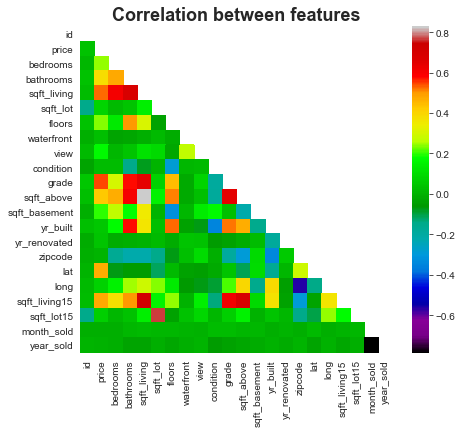

In [68]:
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

There are some areas of high correlation. The highest is where "sqft_above" meets "sqft_living". "sqft_living15" also correlates highly across other features. Those will be columns we look forward to removing.

In [69]:
df.drop(columns= ['sqft_above', 'sqft_living15','sqft_lot15', 'season', 
                  'quadrant'], inplace= True)
# df.info()

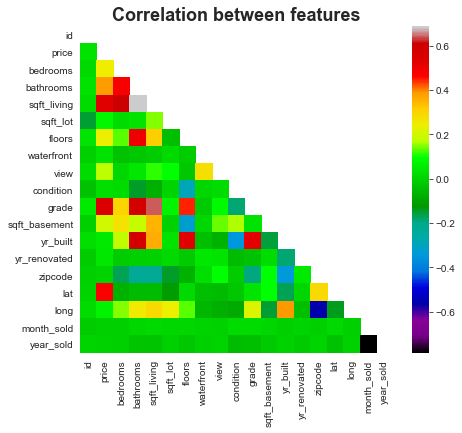

In [70]:
corr1 = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

#### Baseline Model

In [71]:
df1 = df.copy()
outcome = 'price'
x_cols = df1.drop(['price'], axis= 1).columns
x_cols

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'month_sold', 'year_sold'],
      dtype='object')

In [72]:
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1860.
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:41   Log-Likelihood:            -2.3651e+05
No. Observations:               18352   AIC:                         4.731e+05
Df Residuals:                   18333   BIC:                         4.732e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.762e+07   5.14e+06     -7.316      0.000   -4.77e+07   -2.75e+07
id             8.928e-07    2.5e-07      3.575      0.000    4.03e-07    1.38e-06
bedrooms      -1.068e+04   1099.218     -9.715      0.000   -1.28e+04   -8524.151
bathrooms      2.319e+04   1796.898     12.906      0.000    1.97e+04    2.67e+04
sqft_living      79.1500      2.049     38.629      0.000      75.134      83.166
sqft_lot          0.2549      0.024     10.777      0.000       0.209       0.301
floors         2.579e+04   1894.932     13.609      0.000    2.21e+04    2.95e+04
waterfront     1.024e+05   1.69e+04      6.061      0.000    6.93e+04    1.36e+05
view           2.754e+04   1365.579     20.164      0.000    2.49e+04    3.02e+04
condition      2.046e+04   1215.131     16.838      0.000    1.81e+04    2.28e+04
grade          6.467e+04   1160.725     55.712      0.000    6.24e+04    6.69e+04
sqft_basement    -3.6581      2.499     -1.464      0.143      -8.557       1.241
yr_built      -1475.3798     39.247    -37.592      0.000   -1552.308   -1398.451
yr_renovated      3.9208      2.294      1.709      0.087      -0.576       8.417
zipcode        -161.5744     16.970     -9.521      0.000    -194.836    -128.313
lat            5.129e+05   5337.768     96.093      0.000    5.02e+05    5.23e+05
long           1.344e+04   6579.230      2.043      0.041     548.621    2.63e+04
month_sold       98.2063    364.286      0.270      0.787    -615.828     812.241
year_sold      1.654e+04   2439.482      6.779      0.000    1.18e+04    2.13e+04
==============================================================================
Omnibus:                      520.650   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              680.610
Skew:                           0.334   Prob(JB):                    1.61e-148
Kurtosis:                       3.666   Cond. No.                     3.97e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Baseline $R^{2}$ = 0.646

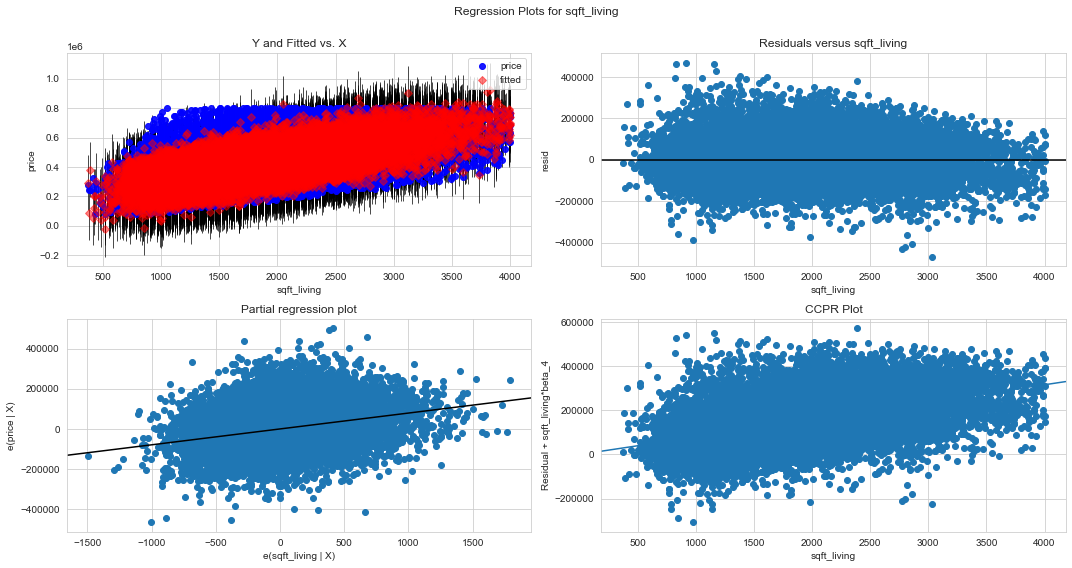

In [73]:
fig = plt.figure(figsize= (15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig)
plt.show()

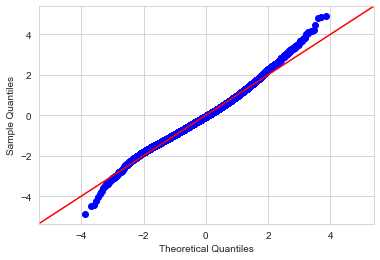

In [74]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### One-hot encoding and binning

Time to work with the data within some of these features to clean it up.
Features we'll focus on are:
* bathrooms
* floors
* grades
* sqft_basement
* view
* yr_renovated

#### Bathrooms and Floors

In [75]:
# make changes to df copy and see if model does better
df1 = df.copy()

In [76]:
# look at bathroom data
df1.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 1.5 , 2.5 , 1.75, 2.75, 3.25, 3.5 , 0.75,
       4.  , 1.25, 3.75, 4.5 , 4.75, 0.5 , 5.  , 4.25, 5.25])

In [77]:
# Only count whole bathrooms
df1['bathrooms'] = df1.bathrooms.astype(int)
df1.bathrooms.unique()

array([1, 2, 3, 0, 4, 5])

In [78]:
# A house shouldn't have 0 bathrooms. Let's change the zeros to ones.
df1['bathrooms'] = df1['bathrooms'].map(lambda x: 1 if x == 0 else x)

In [79]:
# check out the values of floors
df1.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [80]:
# Change floors that end in .5 to even number
df1['floors'] = df1['floors'].map(lambda x: x + 0.5)
df1['floors'] = df1.floors.astype(int)
df1.floors.unique()

array([1, 2, 3, 4])

In [81]:
outcome = 'price'
x_cols = df1.drop(['price'], axis= 1).columns

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1852.
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:42   Log-Likelihood:            -2.3653e+05
No. Observations:               18352   AIC:                         4.731e+05
Df Residuals:                   18333   BIC:                         4.733e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.719e+07   5.15e+06     -7.224      0.000   -4.73e+07   -2.71e+07
id             8.965e-07    2.5e-07      3.584      0.000    4.06e-07    1.39e-06
bedrooms      -1.017e+04   1092.528     -9.311      0.000   -1.23e+04   -8031.030
bathrooms      1.572e+04   1605.579      9.790      0.000    1.26e+04    1.89e+04
sqft_living      82.5141      2.010     41.046      0.000      78.574      86.454
sqft_lot          0.2445      0.024     10.334      0.000       0.198       0.291
floors         2.563e+04   1638.360     15.644      0.000    2.24e+04    2.88e+04
waterfront     1.019e+05   1.69e+04      6.025      0.000    6.88e+04    1.35e+05
view           2.787e+04   1367.215     20.387      0.000    2.52e+04    3.06e+04
condition      2.119e+04   1213.394     17.464      0.000    1.88e+04    2.36e+04
grade          6.551e+04   1159.794     56.487      0.000    6.32e+04    6.78e+04
sqft_basement    -0.1010      2.465     -0.041      0.967      -4.932       4.730
yr_built      -1309.9858     36.772    -35.624      0.000   -1382.063   -1237.908
yr_renovated      5.8008      2.290      2.533      0.011       1.311      10.290
zipcode        -168.5968     16.987     -9.925      0.000    -201.893    -135.300
lat            5.143e+05   5339.398     96.321      0.000    5.04e+05    5.25e+05
long           1.245e+04   6579.412      1.892      0.059    -449.053    2.53e+04
month_sold       96.7663    364.809      0.265      0.791    -618.293     811.825
year_sold      1.641e+04   2442.907      6.718      0.000    1.16e+04    2.12e+04
==============================================================================
Omnibus:                      502.408   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.432
Skew:                           0.327   Prob(JB):                    7.80e-143
Kurtosis:                       3.654   Cond. No.                     3.96e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The $R^{2}$ on this model = 0.645

That is only .001 lower than our original and we haven't dropped anything yet.

But let's see if need to clean up other features, like grade or condition.

#### Grade Binning

In [82]:
print ('waterfront: ', df1.waterfront.unique())
print ('condition: ', df.condition.unique())

waterfront:  [0. 1.]
condition:  [3 5 4 1 2]


In [83]:
print ('grade values: ', df1['grade'].unique())

grade values:  [ 7  6  8  9  5 10  4 11  3]


5__7     10688
7__9      7056
9__11      347
3__5       261
Name: grade, dtype: int64
Sum:  18352


<AxesSubplot:xlabel='grade', ylabel='count'>

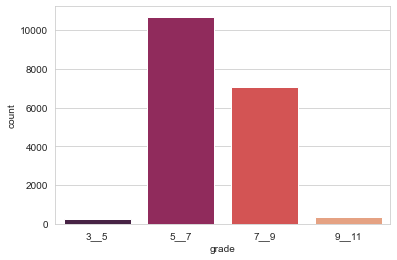

In [84]:
# Let's change waterfront to integers and bin some grades
df1['waterfront'] = df1.waterfront.astype(int)

grade_binned = pd.cut(df['grade'], bins= 4, labels = ['3__5', '5__7', '7__9',
                                                      '9__11'])
print(grade_binned.value_counts())
print ('Sum: ', grade_binned.value_counts().sum())
sns.countplot(x= grade_binned, palette= 'rocket')

In [85]:
df2 = df1.copy()

In [86]:
df2.drop(columns= ['grade'], axis= 1, inplace= True)

In [87]:
df2 = pd.concat([df2, grade_binned], names= ['grade_bin'], axis= 1)

In [88]:
df2.rename(columns={'grade': 'grade_binned'}, inplace= True)

In [89]:
# grade_dummies = pd.get_dummies(df2['grade_binned'], prefix= 'grade_', 
#                                drop_first= True)

In [90]:
# df2.drop(['grade_binned'], axis= 1, inplace= True)

In [91]:
# df2 = pd.concat([df2, grade_dummies], axis= 1)

In [92]:
# df2.head()

<AxesSubplot:>

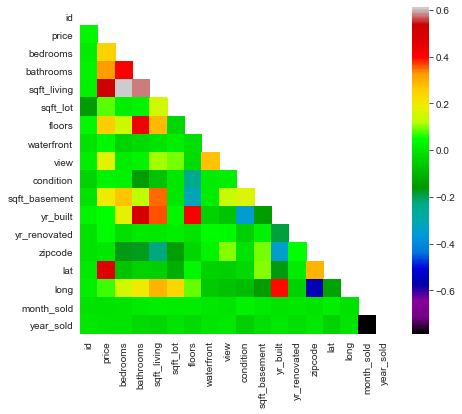

In [93]:
corr2 = df2.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(df2.corr(), cmap= 'nipy_spectral', mask= mask)

In [94]:
outcome = 'price'
x_cols = df2.drop(['price'], axis= 1).columns

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df2).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1518.
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:43   Log-Likelihood:            -2.3708e+05
No. Observations:               18352   AIC:                         4.742e+05
Df Residuals:                   18331   BIC:                         4.744e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.516e+07    5.3e+06     -6.630      0.000   -4.56e+07   -2.48e+07
grade_binned[T.5__7]   6.953e+04   6347.065     10.955      0.000    5.71e+04     8.2e+04
grade_binned[T.7__9]   1.482e+05   6689.194     22.149      0.000    1.35e+05    1.61e+05
grade_binned[T.9__11]  2.354e+05   8786.955     26.793      0.000    2.18e+05    2.53e+05
id                     9.695e-07   2.58e-07      3.763      0.000    4.64e-07    1.47e-06
bedrooms              -1.032e+04   1134.951     -9.089      0.000   -1.25e+04   -8090.495
bathrooms              1.377e+04   1657.462      8.310      0.000    1.05e+04     1.7e+04
sqft_living             102.7889      1.980     51.903      0.000      98.907     106.671
sqft_lot                  0.2490      0.024     10.215      0.000       0.201       0.297
floors                 2.512e+04   1694.983     14.822      0.000    2.18e+04    2.84e+04
waterfront              9.26e+04   1.74e+04      5.312      0.000    5.84e+04    1.27e+05
view                   2.958e+04   1408.664     20.998      0.000    2.68e+04    3.23e+04
condition              2.182e+04   1251.212     17.441      0.000    1.94e+04    2.43e+04
sqft_basement            -8.1020      2.533     -3.198      0.001     -13.067      -3.137
yr_built              -1048.8862     37.355    -28.079      0.000   -1122.106    -975.666
yr_renovated              7.4886      2.362      3.171      0.002       2.860      12.118
zipcode                -191.9174     17.494    -10.970      0.000    -226.207    -157.627
lat                    5.362e+05   5466.327     98.083      0.000    5.25e+05    5.47e+05
long                  -3871.8887   6775.611     -0.571      0.568   -1.72e+04    9408.942
month_sold               37.3878    375.781      0.099      0.921    -699.179     773.955
year_sold              1.495e+04   2516.033      5.942      0.000       1e+04    1.99e+04
==============================================================================
Omnibus:                      413.004   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.822
Skew:                           0.310   Prob(JB):                    4.81e-109
Kurtosis:                       3.518   Cond. No.                     3.96e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Whoa. We went from an $R^2$ of 0.645 to 0.624. Maybe we don't want to bin the grades. Let's go back to using the previous DataFrame.

#### Basement, views, and renovations

Let's turn sqft_basement, yr_renovated, and view into either has or doesn't have.

In [95]:
df3 = df1.copy()

In [96]:
print ('Num of basement values: ', df.sqft_basement.nunique())
df3['has_basement'] = df3['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

Num of basement values:  228


In [97]:
print ('View values: ', df.view.unique())
df3['has_view'] = df3['view'].map(lambda x: 1 if x > 0 else 0)

View values:  [0. 3. 2. 4. 1.]


In [98]:
print ('Num of renovation values: ', df3.yr_renovated.nunique())
df3['had_renovation'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)

Num of renovation values:  69


In [99]:
df3.drop(columns= ['yr_renovated', 'view', 'sqft_basement'], axis= 1, inplace= True)

In [100]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18352 entries, 0 to 18351
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18352 non-null  int64  
 1   price           18352 non-null  float64
 2   bedrooms        18352 non-null  int64  
 3   bathrooms       18352 non-null  int64  
 4   sqft_living     18352 non-null  int64  
 5   sqft_lot        18352 non-null  int64  
 6   floors          18352 non-null  int64  
 7   waterfront      18352 non-null  int64  
 8   condition       18352 non-null  int64  
 9   grade           18352 non-null  int64  
 10  yr_built        18352 non-null  int64  
 11  zipcode         18352 non-null  int64  
 12  lat             18352 non-null  float64
 13  long            18352 non-null  float64
 14  month_sold      18352 non-null  int64  
 15  year_sold       18352 non-null  int64  
 16  has_basement    18352 non-null  int64  
 17  has_view        18352 non-null 

In [101]:
outcome = 'price'
x_cols = df3.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df3).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1865.
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:43   Log-Likelihood:            -2.3649e+05
No. Observations:               18352   AIC:                         4.730e+05
Df Residuals:                   18333   BIC:                         4.732e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -3.47e+07   5.14e+06     -6.752      0.000   -4.48e+07   -2.46e+07
id              8.798e-07    2.5e-07      3.526      0.000    3.91e-07    1.37e-06
bedrooms       -1.014e+04   1089.709     -9.306      0.000   -1.23e+04   -8005.179
bathrooms       1.419e+04   1605.312      8.837      0.000     1.1e+04    1.73e+04
sqft_living       78.9618      1.874     42.145      0.000      75.289      82.634
sqft_lot           0.2521      0.024     10.689      0.000       0.206       0.298
floors          3.026e+04   1579.516     19.156      0.000    2.72e+04    3.34e+04
waterfront      1.391e+05   1.65e+04      8.447      0.000    1.07e+05    1.71e+05
condition       2.078e+04   1206.920     17.218      0.000    1.84e+04    2.31e+04
grade           6.607e+04   1145.655     57.670      0.000    6.38e+04    6.83e+04
yr_built       -1307.1964     36.687    -35.632      0.000   -1379.105   -1235.287
zipcode         -176.1320     16.955    -10.388      0.000    -209.365    -142.899
lat             5.087e+05   5319.823     95.619      0.000    4.98e+05    5.19e+05
long            2.408e+04   6562.091      3.669      0.000    1.12e+04    3.69e+04
month_sold        83.3460    363.963      0.229      0.819    -630.055     796.746
year_sold       1.637e+04   2437.187      6.718      0.000    1.16e+04    2.12e+04
has_basement    1.305e+04   1715.690      7.608      0.000    9690.821    1.64e+04
has_view        6.347e+04   3074.593     20.644      0.000    5.74e+04    6.95e+04
had_renovation  1.182e+04   4556.714      2.594      0.009    2888.511    2.08e+04
==============================================================================
Omnibus:                      513.183   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.265
Skew:                           0.327   Prob(JB):                    3.16e-148
Kurtosis:                       3.679   Cond. No.                     3.97e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We went from $R^2$ = 0.645 to 0.647. Let's keep these changes.

#### Use Dummy Variables

In [102]:
# use this to see which columns could be categorical or continuous data
continuous = []
categorical = []

for col in df3.columns:
    if (df3[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [103]:
continuous

['id',
 'price',
 'sqft_living',
 'sqft_lot',
 'yr_built',
 'zipcode',
 'lat',
 'long']

In [104]:
categorical

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'month_sold',
 'year_sold',
 'has_basement',
 'has_view',
 'had_renovation']

##### Bedrooms, Bathrooms, Floors and Grade

The categorical columns are indeed categorical. Let's use dummy variables and see what happens to our model.

In [105]:
df4 = df3.copy()

In [106]:
#OHE bedrooms, bathrooms, and floors
bed_dum = pd.get_dummies(df4['bedrooms'], prefix= 'bed', drop_first= True)
bath_dum = pd.get_dummies(df4['bathrooms'], prefix= 'bath', drop_first= True)
flr_dum = pd.get_dummies(df4['floors'], prefix= 'flr', drop_first= True)
grade_dum = pd.get_dummies(df4['grade'], prefix= 'grd', drop_first= True)
mo_sold_dum = pd.get_dummies(df4['month_sold'], prefix= 'mo_sold', 
                             drop_first= True)

In [107]:
df4 = df4.drop(['bedrooms', 'bathrooms', 'floors', 'grade', 'month_sold'],
               axis= 1)

In [108]:
df4 = pd.concat([df4, bed_dum, bath_dum, flr_dum, grade_dum, mo_sold_dum],
                axis= 1)

In [109]:
df4.head()

id     price  sqft_living  sqft_lot  waterfront  condition  \
0  7129300520  221900.0         1180      5650           0          3   
1  6414100192  538000.0         2570      7242           0          3   
2  5631500400  180000.0          770     10000           0          3   
3  2487200875  604000.0         1960      5000           0          5   
4  1954400510  510000.0         1680      8080           0          3   

   yr_built  zipcode      lat     long  year_sold  has_basement  has_view  \
0      1955    98178  47.5112 -122.257       2014             0         0   
1      1951    98125  47.7210 -122.319       2014             1         0   
2      1933    98028  47.7379 -122.233       2015             0         0   
3      1965    98136  47.5208 -122.393       2014             1         0   
4      1987    98074  47.6168 -122.045       2015             0         0   

   had_renovation  bed_2  bed_3  bed_4  bed_5  bed_6  bath_2  bath_3  bath_4  \
0               0      0      1      0      0      0       0       0       0   
1               1      0      1      0      0      0       1       0       0   
2               0      1      0      0      0      0       0       0       0   
3               0      0      0      1      0      0       0       1       0   
4               0      0      1      0      0      0       1       0       0   

   bath_5  flr_2  flr_3  flr_4  grd_4  grd_5  grd_6  grd_7  grd_8  grd_9  \
0       0      0      0      0      0      0      0      1      0      0   
1       0      1      0      0      0      0      0      1      0      0   
2       0      0      0      0      0      0      1      0      0      0   
3       0      0      0      0      0      0      0      1      0      0   
4       0      0      0      0      0      0      0      0      1      0   

   grd_10  grd_11  mo_sold_2  mo_sold_3  mo_sold_4  mo_sold_5  mo_sold_6  \
0       0       0          0          0          0          0          0   
1       0       0          0          0          0          0          0   
2       0       0          1          0          0          0          0   
3       0       0          0          0          0          0          0   
4       0       0          1          0          0          0          0   

   mo_sold_7  mo_sold_8  mo_sold_9  mo_sold_10  mo_sold_11  mo_sold_12  
0          0          0          0           1           0           0  
1          0          0          0           0           0           1  
2          0          0          0           0           0           0  
3          0          0          0           0           0           1  
4          0          0          0           0           0           0

In [110]:
outcome = 'price'
x_cols = df4.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df4).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     774.7
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:43   Log-Likelihood:            -2.3639e+05
No. Observations:               18352   AIC:                         4.729e+05
Df Residuals:                   18307   BIC:                         4.732e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.638e+07   9.65e+06     -6.882      0.000   -8.53e+07   -4.75e+07
id              8.556e-07   2.49e-07      3.442      0.001    3.68e-07    1.34e-06
sqft_living       76.2659      1.919     39.750      0.000      72.505      80.027
sqft_lot           0.2562      0.024     10.892      0.000       0.210       0.302
waterfront      1.375e+05   1.64e+04      8.376      0.000    1.05e+05     1.7e+05
condition        2.13e+04   1210.049     17.602      0.000    1.89e+04    2.37e+04
yr_built       -1286.0010     37.867    -33.961      0.000   -1360.224   -1211.778
zipcode         -175.5741     16.982    -10.339      0.000    -208.861    -142.287
lat             5.102e+05   5355.086     95.265      0.000       5e+05    5.21e+05
long            1.791e+04   6638.691      2.697      0.007    4893.567    3.09e+04
year_sold       3.189e+04   4724.474      6.751      0.000    2.26e+04    4.12e+04
has_basement    1.473e+04   1746.783      8.433      0.000    1.13e+04    1.82e+04
has_view         6.28e+04   3068.962     20.464      0.000    5.68e+04    6.88e+04
had_renovation  1.358e+04   4548.411      2.986      0.003    4667.897    2.25e+04
bed_2           7271.7624   7340.798      0.991      0.322   -7116.888    2.17e+04
bed_3          -5660.7048   7337.195     -0.772      0.440      -2e+04    8720.884
bed_4          -1.056e+04   7540.921     -1.400      0.161   -2.53e+04    4222.810
bed_5          -2.747e+04   8131.129     -3.379      0.001   -4.34e+04   -1.15e+04
bed_6          -3.067e+04   1.08e+04     -2.838      0.005   -5.19e+04   -9489.017
bath_2           1.48e+04   1981.519      7.469      0.000    1.09e+04    1.87e+04
bath_3          2.703e+04   3667.388      7.370      0.000    1.98e+04    3.42e+04
bath_4          2.389e+04   1.39e+04      1.715      0.086   -3410.352    5.12e+04
bath_5          8.449e+04   3.97e+04      2.127      0.033    6635.827    1.62e+05
flr_2           3.097e+04   1805.586     17.155      0.000    2.74e+04    3.45e+04
flr_3           5.213e+04   4493.883     11.599      0.000    4.33e+04    6.09e+04
flr_4           7.302e+04    3.9e+04      1.874      0.061   -3356.063    1.49e+05
grd_4          -1.563e+05   9.71e+04     -1.610      0.107   -3.47e+05     3.4e+04
grd_5          -1.473e+05   9.57e+04     -1.540      0.124   -3.35e+05    4.02e+04
grd_6          -1.157e+05   9.55e+04     -1.211      0.226   -3.03e+05    7.15e+04
grd_7          -5.105e+04   9.56e+04     -0.534      0.593   -2.38e+05    1.36e+05
grd_8           1.869e+04   9.56e+04      0.196      0.845   -1.69e+05    2.06e+05
grd_9           9.478e+04   9.56e+04      0.991      0.322   -9.27e+04    2.82e+05
grd_10          1.442e+05   9.58e+04      1.505      0.132   -4.35e+04    3.32e+05
grd_11          1.761e+05   9.88e+04      1.783      0.075   -1.74e+04     3.7e+05
mo_sold_2   

$R^2$ is at 0.651 and we now have some higher p-values that we could potentially drop.

Other interesting things we can now see:
* having 5 bathrooms makes a dramatic increase in price
* additional bedrooms decrease value
* having a view increases the price drastically
* prices increase starting at grade 8 and above

* now that the grades are separate - none of them meet the 0.05 measurement of statistical significance. 

Now that we are done transforming some features, let's save this so we can use it later if needed.

In [111]:
# Save all changes to a csv file

df4.to_csv('df_features_clean')

In [112]:
df_pairplot = df[['price', 'sqft_living', 'yr_built','condition', 'zipcode']]

In [113]:
df_pairplot.head()

price  sqft_living  yr_built  condition  zipcode
0  221900.0         1180      1955          3    98178
1  538000.0         2570      1951          3    98125
2  180000.0          770      1933          3    98028
3  604000.0         1960      1965          5    98136
4  510000.0         1680      1987          3    98074

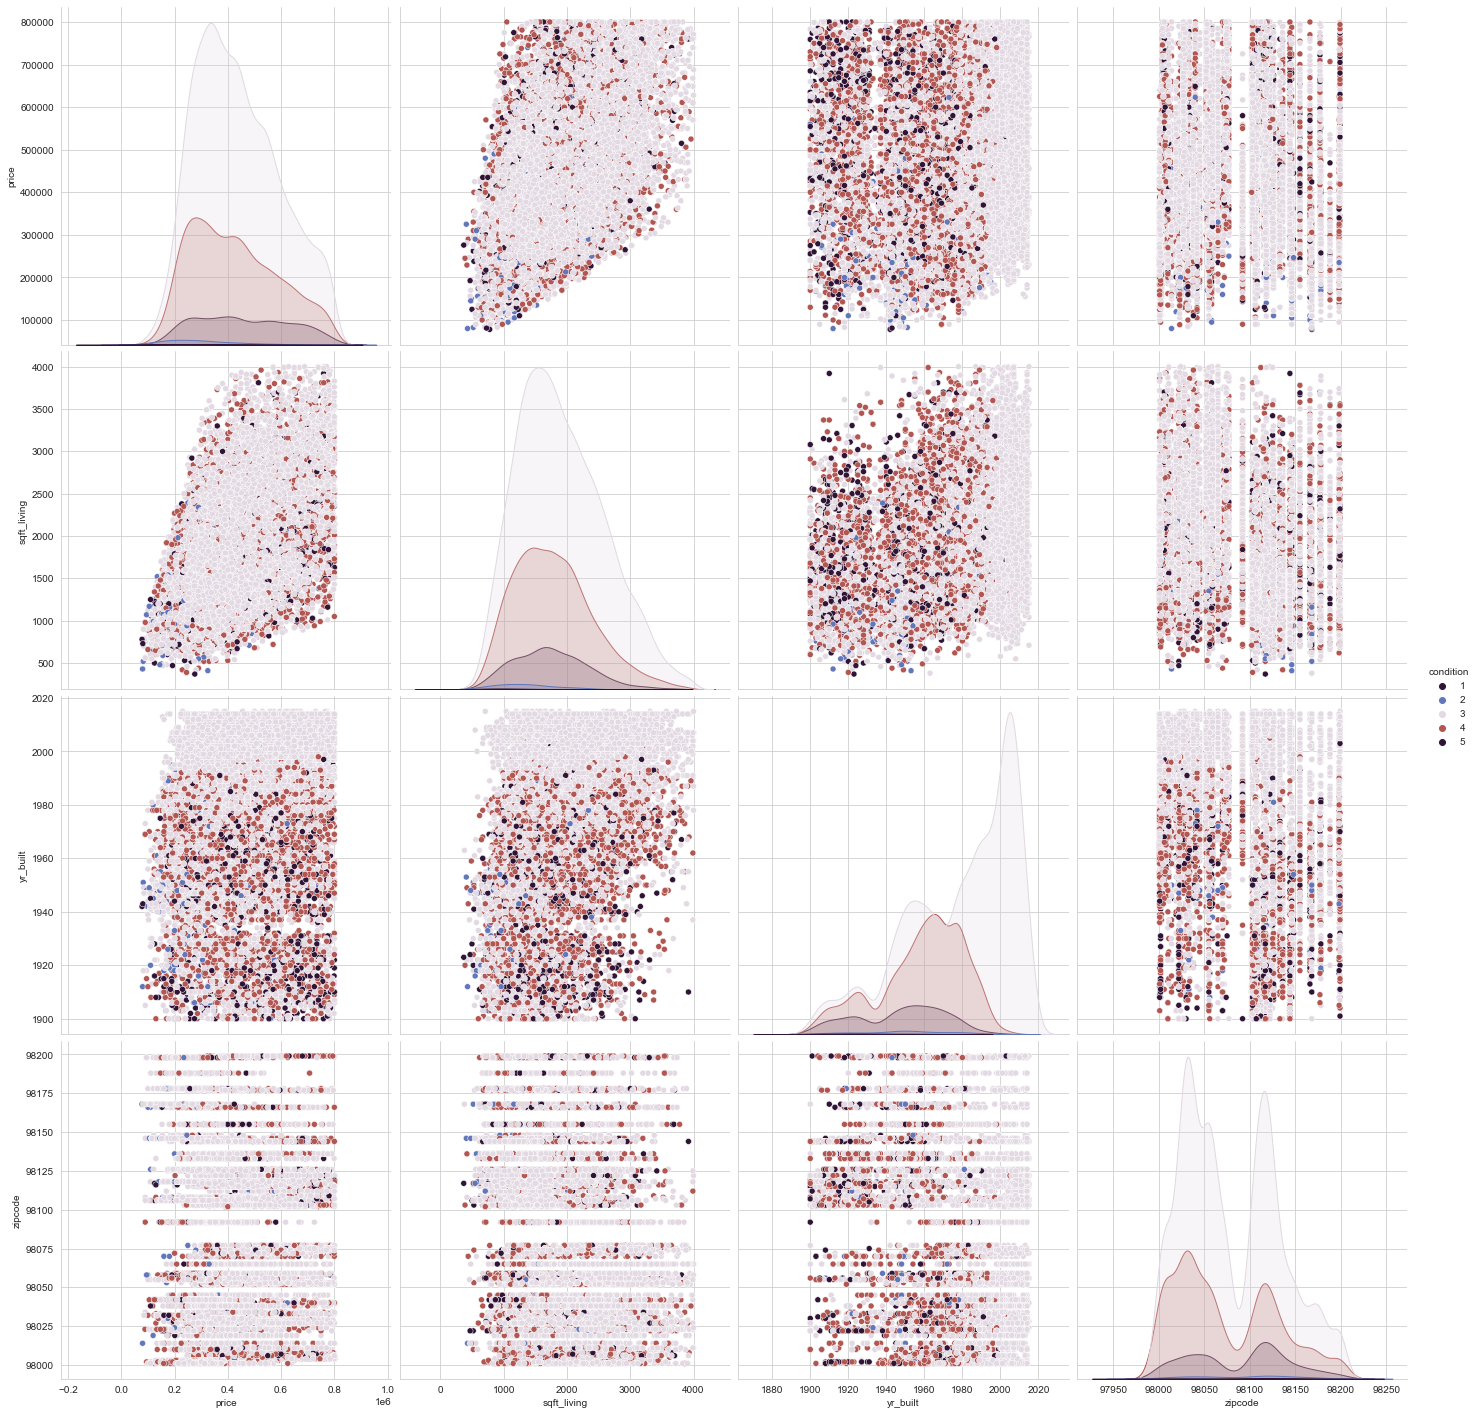

In [114]:
g = sns.pairplot(df_pairplot, hue= 'condition', palette= 'twilight_shifted', 
                 height= 5)

## Modeling and Prediction

### First Model

In [115]:
df

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520  221900.0         3       1.00         1180      5650   
1      6414100192  538000.0         3       2.25         2570      7242   
2      5631500400  180000.0         2       1.00          770     10000   
3      2487200875  604000.0         4       3.00         1960      5000   
4      1954400510  510000.0         3       2.00         1680      8080   
...           ...       ...       ...        ...          ...       ...   
18347   263000018  360000.0         3       2.50         1530      1131   
18348  6600060120  400000.0         4       2.50         2310      5813   
18349  1523300141  402101.0         2       0.75         1020      1350   
18350   291310100  400000.0         3       2.50         1600      2388   
18351  1523300157  325000.0         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_basement  yr_built  \
0         1.0         0.0   0.0          3      7            0.0      1955   
1         2.0         0.0   0.0          3      7          400.0      1951   
2         1.0         0.0   0.0          3      6            0.0      1933   
3         1.0         0.0   0.0          5      7          910.0      1965   
4         1.0         0.0   0.0          3      8            0.0      1987   
...       ...         ...   ...        ...    ...            ...       ...   
18347     3.0         0.0   0.0          3      8            0.0      2009   
18348     2.0         0.0   0.0          3      8            0.0      2014   
18349     2.0         0.0   0.0          3      7            0.0      2009   
18350     2.0         0.0   0.0          3      8            0.0      2004   
18351     2.0         0.0   0.0          3      7            0.0      2008   

       yr_renovated  zipcode      lat     long  month_sold  year_sold  
0               0.0    98178  47.5112 -122.257          10       2014  
1            1991.0    98125  47.7210 -122.319          12       2014  
2               0.0    98028  47.7379 -122.233           2       2015  
3               0.0    98136  47.5208 -122.393          12       2014  
4               0.0    98074  47.6168 -122.045           2       2015  
...             ...      ...      ...      ...         ...        ...  
18347           0.0    98103  47.6993 -122.346           5       2014  
18348           0.0    98146  47.5107 -122.362           2       2015  
18349           0.0    98144  47.5944 -122.299           6       2014  
18350           0.0    98027  47.5345 -122.069           1       2015  
18351           0.0    98144  47.5941 -122.299          10       2014  

[18352 rows x 19 columns]

In [116]:
df5 = df4.copy()

In [117]:
df5.drop(['id', 'zipcode'], axis= 1, inplace= True)

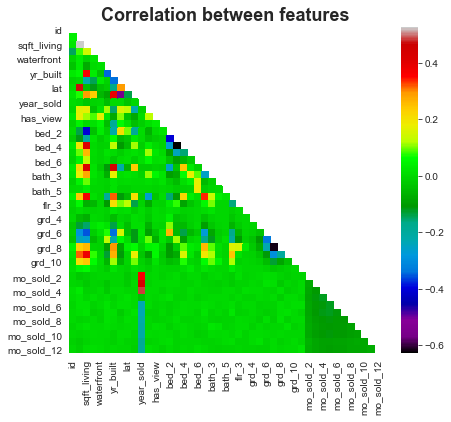

In [118]:
corr3 = df4.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr3, dtype=bool))
sns.heatmap(df4.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

In [119]:
df_corr_stack = df4.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

In [132]:
df_corr_stack[(df_corr_stack.cc > .45) & (df_corr_stack.cc < 1)]

cc
pairs                           
(bed_4, bed_3)          0.626669
(grd_7, grd_8)          0.615039
(long, zipcode)         0.559568
(sqft_living, price)    0.528371
(mo_sold_4, year_sold)  0.486823
(price, lat)            0.472662

In [121]:
outcome = 'price'
x_cols = df5.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df5).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     803.7
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:31:57   Log-Likelihood:            -2.3645e+05
No. Observations:               18352   AIC:                         4.730e+05
Df Residuals:                   18309   BIC:                         4.733e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -7.932e+07   9.59e+06     -8.269      0.000   -9.81e+07   -6.05e+07
sqft_living       76.4404      1.925     39.716      0.000      72.668      80.213
sqft_lot           0.2446      0.023     10.497      0.000       0.199       0.290
waterfront      1.391e+05   1.65e+04      8.444      0.000    1.07e+05    1.71e+05
condition       2.239e+04   1208.020     18.534      0.000       2e+04    2.48e+04
yr_built       -1251.4652     37.811    -33.098      0.000   -1325.578   -1177.353
lat             4.974e+05   5231.623     95.072      0.000    4.87e+05    5.08e+05
long            4.843e+04   6005.926      8.063      0.000    3.67e+04    6.02e+04
year_sold       3.189e+04   4739.463      6.728      0.000    2.26e+04    4.12e+04
has_basement    1.368e+04   1749.199      7.823      0.000    1.03e+04    1.71e+04
has_view        6.034e+04   3064.214     19.692      0.000    5.43e+04    6.63e+04
had_renovation  1.333e+04   4562.603      2.921      0.003    4384.455    2.23e+04
bed_2           7291.5129   7363.820      0.990      0.322   -7142.263    2.17e+04
bed_3          -4203.2457   7359.243     -0.571      0.568   -1.86e+04    1.02e+04
bed_4          -9041.7992   7563.585     -1.195      0.232   -2.39e+04    5783.534
bed_5           -2.58e+04   8155.446     -3.164      0.002   -4.18e+04   -9816.316
bed_6          -2.827e+04   1.08e+04     -2.609      0.009   -4.95e+04   -7028.178
bath_2          1.546e+04   1986.806      7.783      0.000    1.16e+04    1.94e+04
bath_3          2.662e+04   3678.642      7.238      0.000    1.94e+04    3.38e+04
bath_4          2.237e+04    1.4e+04      1.601      0.109   -5015.007    4.98e+04
bath_5           8.98e+04   3.98e+04      2.254      0.024    1.17e+04    1.68e+05
flr_2           2.939e+04   1803.823     16.292      0.000    2.59e+04    3.29e+04
flr_3           4.912e+04   4499.014     10.918      0.000    4.03e+04    5.79e+04
flr_4           6.965e+04   3.91e+04      1.782      0.075   -6961.703    1.46e+05
grd_4           -1.52e+05   9.74e+04     -1.561      0.119   -3.43e+05    3.89e+04
grd_5          -1.455e+05    9.6e+04     -1.516      0.129   -3.34e+05    4.26e+04
grd_6          -1.153e+05   9.58e+04     -1.203      0.229   -3.03e+05    7.25e+04
grd_7          -4.865e+04   9.59e+04     -0.507      0.612   -2.37e+05    1.39e+05
grd_8           2.216e+04   9.59e+04      0.231      0.817   -1.66e+05     2.1e+05
grd_9           9.802e+04   9.59e+04      1.022      0.307      -9e+04    2.86e+05
grd_10          1.475e+05   9.61e+04      1.535      0.125   -4.09e+04    3.36e+05
grd_11          1.781e+05   9.91e+04      1.798      0.072   -1.61e+04    3.72e+05
mo_sold_2       6022.4880   4385.295      1.373      0.170   -2573.099    1.46e+04
mo_sold_3       2.036e+04   4074.117      4.998      0.000    1.24e+04    2.83e+04
mo_sold_4   

### Log Transform

### Train test split

### Improving baseline model

In [122]:
# get rid of columns you won't use
# https://www.youtube.com/watch?v=8_Le51miL-8
# https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [123]:
# log transform

In [124]:
# df2 = df1[['price', 'waterfront', 'yr_built', 'sqft_living15', 'zipcode']]

In [125]:
# pd.plotting.scatter_matrix(df2, figsize= [11,11]);

In [126]:
# df['zipcode'].hist()
# plt.show()

In [127]:
# df.groupby('lat')['sqft_living'].mean().nlargest(5)
# df.groupby('lat')['sqft_living'].mean().min()
# df.groupby('long')['sqft_living'].mean().max()
# df.loc[(df['sqft_living'] <= 1200) & (df['sqft_living15'] > 2000)]
# df.loc[(df['sqft_living'] >= 3000)]
# df.groupby('long')['sqft_living'].mean().nlargest(5)

# for reference - delete when finished
# df_id_dups.groupby('date')['id'].count()
# df_id_dups= df_id_dups.groupby(['id']).unique().count()

In [128]:
# create boxplot with all columns
# sns.boxplot(data=df, orient= 'h')

# # drop price, sqft_lot, zipcode, and sqft_lot15 to see rest of columns better
# boxplot_df.drop(['price', 'sqft_lot', 'sqft_lot15', 'zipcode'], axis= 1, inplace= True)

# # plot only one column in boxplot
# print (df['price'].nlargest(5))
# sns.boxplot(x= df['price'])

In [129]:
# z test, z score
# How to remove everything after 2 standard deviations - can also use lambda
# df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]
# df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]

#can filter by column too - here "B" is name of column
# df[((df.B - df.B.mean()) / df.B.std()).abs() < 2]

In [130]:
# First, let's look at houses that were built from 1900 - 1940 that
# had renovations since the year 2000
# reno_1940 = len(df.loc[(df['yr_built'] <= 1940) & (df['yr_renovated'] >= 2000)])
# print('# of houses built before 1940 that had renovation within 15 years:', 
#       reno_1940)
# print('% of houses that had recent reno and built before 1940: ',
#      reno_1940 / len(df['yr_built']))